In [12]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [1]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
# create engine to hawaii.sqlite
# Path to sqlite
database_path = "./Resources/hawaii.sqlite"

# Create an engine that can talk to the database
engine = create_engine(f"sqlite:///{database_path}", echo=False)

In [3]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [4]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station


In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
latestDate = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(f"The most recent date in the data set is {latestDate[0]}")

The most recent date in the data set is 2017-08-23


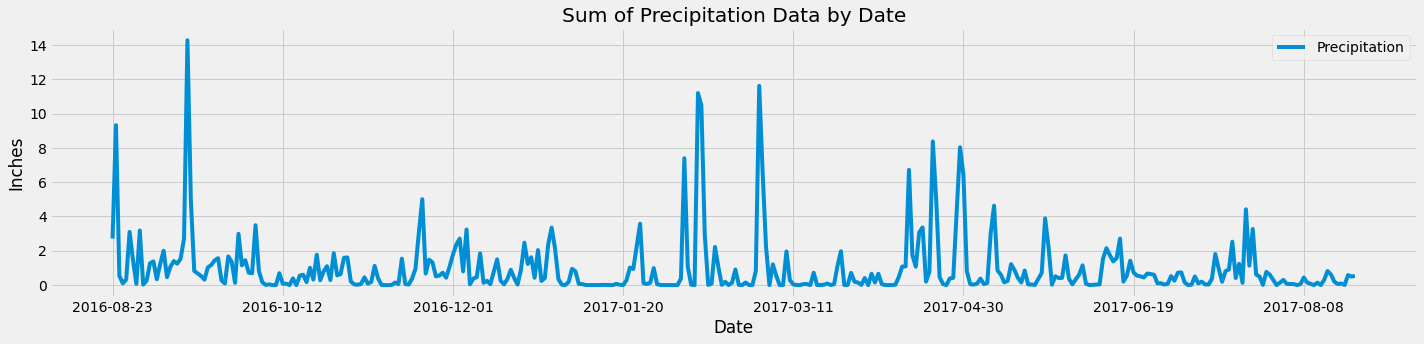

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
# print(query_date)

# Perform a query to retrieve the data and precipitation scores
precipScores = session.query(Measurements.station, Measurements.date, Measurements.prcp).filter(Measurements.date >= query_date).\
    order_by(Measurements.date).all()
# precipScores

# Save the query results as a Pandas DataFrame and set the index to the date column
prcpScores_df = pd.DataFrame(precipScores, columns=['Stations','Date','Precipitation'])
prcpSums_df = prcpScores_df.groupby("Date").sum()

# Use Pandas Plotting with Matplotlib to plot the data
prcpSums_df.plot.line(y="Precipitation", ylabel="Inches",title="Sum of Precipitation Data by Date",figsize=(20,5))
plt.tight_layout()



In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
tests = ['mean','median','var','min','max','sum']
prcpStats_df = prcpScores_df.groupby("Date").agg({"Precipitation":tests})
print(f"Below is the summary statistics for the precipitation data:")
prcpStats_df.head(10)

Below is the summary statistics for the precipitation data:


Precipitation                                   
                    mean median       var   min   max   sum
Date                                                       
2016-08-23      0.451667  0.100  0.499097  0.00  1.79  2.71
2016-08-24      1.555000  1.800  0.706510  0.08  2.28  9.33
2016-08-25      0.077143  0.080  0.005157  0.00  0.21  0.54
2016-08-26      0.016667  0.015  0.000267  0.00  0.04  0.10
2016-08-27      0.064000  0.020  0.006680  0.00  0.18  0.32
2016-08-28      0.516667  0.140  0.620427  0.01  2.07  3.10
2016-08-29      0.243333  0.105  0.121547  0.00  0.90  1.46
2016-08-30      0.011667  0.000  0.000417  0.00  0.05  0.07
2016-08-31      0.636000  0.240  1.044030  0.10  2.46  3.18
2016-09-01      0.006000  0.000  0.000080  0.00  0.02  0.03

# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number stations in the dataset
stationData = session.query(Stations.station, Stations.name, Measurements.date, Measurements.tobs).filter(Stations.station == Measurements.station).all()

stationCount = len(stationData)
print(f"There are {stationCount} station datapoints in the dataset.")

There are 19550 station datapoints in the dataset.


In [27]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
activeStations =session.query(Stations.station, Stations.name,func.count(Measurements.station)).\
    filter(Stations.station == Measurements.station).\
    group_by(Measurements.station).\
    order_by(func.count(Measurements.station).desc()).all()

print(f"{activeStations[0][1][:12]} has the highest number of observations with {activeStations[0][2]}.")
print()
print(f"The most active stations are:")
activeStations

WAIHEE 837.5 has the highest number of observations with 2772.

The most active stations are:


[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [31]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stationIDS = [result[0] for result in activeStations[:10]]
topStation = stationIDS[0]

stationData_df = pd.DataFrame(stationData, columns=['StationID', 'Name','Date','Temperature'])

tests = ['min','max','mean']
topData_df = stationData_df.loc[stationData_df["StationID"] == topStation,:]
topStats_df = topData_df.groupby("Name").agg({"Temperature":tests})

topName = list(topData_df['Name'])[1]
topStats_df

Temperature                 
                            min   max       mean
Name                                            
WAIHEE 837.5, HI US        54.0  85.0  71.663781

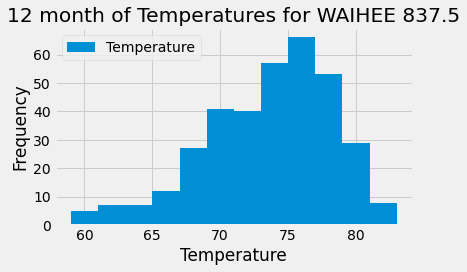

In [37]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
mostActive = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == topStation).\
    filter(Measurements.date >= query_date).\
    order_by(Measurements.date).all()
topstation_df = pd.DataFrame(mostActive, columns=['StationID','Date','Temperature'])
topstation_df.plot.hist(bins=12, title=f"12 month of Temperatures for {topName[:12]}")
plt.xlabel("Temperature")
plt.tight_layout()


# Close session

In [34]:
# Close Session
session.close()